In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
from typing import Optional
from dm_control.rl.control import PhysicsError
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from joblib import Parallel, delayed, parallel_config
from flygym.examples.vision_connectome_model import (
    NMFRealisticVision,
    visualize_vision,
)
from flygym.examples.head_stabilization import HeadStabilizationInferenceWrapper
from flygym.examples.head_stabilization import get_head_stabilization_model_paths


from flygym import Fly, Camera, Parameters
from flygym.arena import FlatTerrain, BaseArena
from flygym.examples.vision_connectome_model.network import *
from flygym.examples.vision_connectome_model.viz import *
from connectome_behavior import *

In [2]:
class OptomotorTerrain(FlatTerrain):
    def __init__(
        self,
        n=18,
        height=100,
        distance=12,
        ang_speed=1,
        light=True,
        dark=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.height = height
        self.ang_speed = ang_speed

        self.cylinders = []
        self.phase = 0
        self.curr_time = 0
        
        if not light:
            palette1 =(0,0,0,0)
        else:
            palette1 = (0,0,0,1)
        
        if not dark:
            palette2=(0,0,0,0)
        else:
            palette2= (1,1,1,1)
            
        palette = (palette1, palette2)

        cylinder_material = self.root_element.asset.add(
            "material", name="cylinder", reflectance=0.1
        )
        init_pos = np.exp(2j * np.pi * np.arange(n) / n) * distance
        radius = np.abs(init_pos[1] - init_pos[0]) / 2
        self.init_pos = init_pos

        for i, pos in enumerate(self.init_pos):
            cylinder = self.root_element.worldbody.add(
                "body",
                name=f"cylinder_{i}",
                mocap=True,
                pos=(pos.real, pos.imag, self.height / 2),
            )

            cylinder.add(
                "geom",
                type="cylinder",
                size=(radius, self.height / 2),
                rgba=palette[i % len(palette)],
                material=cylinder_material,
            )

            self.cylinders.append(cylinder)

        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(0, 0, 25),
            euler=(0, 0, 0),
            fovy=45,
        )

    def reset(self, physics):
        """Resets the position of the cylinders and the phase of the grating pattern."""
        self.phase = 0
        self.curr_time = 0

        for i, p in enumerate(self.init_pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )

    def step(self, dt, physics):
        """Steps the phase of the grating pattern and updates the position of the cylinders."""

        if self.curr_time % 1 < 1 / 2:
            self.phase -= dt * self.ang_speed
        else:
            self.phase += dt * self.ang_speed

        self.curr_time += dt

        pos = np.exp(self.phase * 1j) * self.init_pos

        for i, p in enumerate(pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )

In [3]:

class LoomingTerrain(BaseArena):
    def __init__(
        self,
        move_direction = "towards",
        lateral_magnitude = 9,
        move_speed = 10,
        obj_radius = 2,
        init_ball_pos = (25, 0),
        size = (300, 300),
        friction = (1, 0.005, 0.0001),
    ):
        super().__init__()
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.lateral_magnitude = lateral_magnitude
        self.move_direction = move_direction
        if move_direction == "towards":
            self.x_mult = -1
        elif move_direction == "away":
            self.x_mult = 1
        else:
            raise ValueError("Invalid move_direction")

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(60, 60),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(15, 0, 35),
            euler=(0, 0, 0),
            fovy=45,
        )

        #self.birdeye_cam_zoom = self.root_element.worldbody.add(
        #    "camera",
        #    name="birdeye_cam_zoom",
        #    mode="fixed",
        #    pos=(15, 0, 20),
        #    euler=(0, 0, 0),
        #    fovy=45,
        #)
    
    def get_spawn_position(self, rel_pos, rel_angle):
        return rel_pos, rel_angle

    def step(self, dt, physics):
        heading_vec = np.array(
            [1.0 * self.lateral_magnitude * self.x_mult, 0]
        )
        heading_vec /= np.linalg.norm(heading_vec)
        self.ball_pos[:2] += self.move_speed * heading_vec * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos


In [4]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# fmt: off
cells = [
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm2", "Tm3", "Tm4", "Tm5Y", "Tm5a", "Tm5b", "Tm5c", "Tm9", "Tm16", "Tm20",
    "Tm28", "Tm30", "TmY3", "TmY4", "TmY5a", "TmY9", "TmY10", "TmY13", "TmY14", "TmY15",
    "TmY18"
]
# fmt: on

output_dir = Path("./outputs/optomotor_connectome/baseline_response/")
stabilization_model_path, scaler_param_path = get_head_stabilization_model_paths()


def run_simulation(
    fly_behavior,
    arena,
    run_time: float = 1.0,
    head_stabilization_model: Optional[HeadStabilizationInferenceWrapper] = None,
):
    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        vision_refresh_rate=500,
        neck_kp=1000,
        head_stabilization_model=head_stabilization_model,
    )

    cam = Camera(
        fly=fly,
        camera_id="birdeye_cam",
        play_speed=0.2,
        window_size=(800, 608),
        fps=24,
        play_speed_text=False,
    )

    sim = NMFRealisticVision(
        fly=fly,
        cameras=[cam],
        arena=arena,
    )

    obs, info = sim.reset(seed=0)
    obs_hist = []
    info_hist = []
    rendered_image_snapshots = []
    vision_observation_snapshots = []
    nn_activities_snapshots = []
    
    # This array will serve as the basis for the motion of the fly during optomotor response
    turn_bias = np.array([0, 0])
    # Main simulation loop
    for i in trange(int(run_time / sim.timestep)):
        if info["vision_updated"]:
            nn_activities = info["nn_activities"]
            if(fly_behavior == "Immobile"):
                turn_bias = immobile_behavior()
            elif(fly_behavior == "SimpleSTDT4"):
                turn_bias = simple_std_t4_behavior(nn_activities, sim)
            elif(fly_behavior == "AdaptativeSTDT4"):
                turn_bias = adaptative_std_t4_behavior(nn_activities, sim)
            elif(fly_behavior == "SimpleSTDT45"):
                turn_bias = simple_std_t45_behavior(nn_activities, sim)
            elif(fly_behavior == "AdaptativeSTDT45"):
                turn_bias = adaptative_std_t45_behavior(nn_activities, sim)
            elif(fly_behavior == "RealisticProportional"):
                turn_bias = realistic_proportional_behavior(nn_activities, sim)
            else:
                print("Error while choosing behavior type.")
                return
            print(turn_bias)

            
        try:
            obs, _, _, _, info = sim.step(action = turn_bias)
        except PhysicsError:
            print("Physics error, ending simulation early")
            break
        obs_hist.append(obs)
        info_hist.append(info)
        rendered_img = sim.render()[0]
        if rendered_img is not None:
            rendered_image_snapshots.append(rendered_img)
            vision_observation_snapshots.append(obs["vision"])
            nn_activities_snapshots.append(info["nn_activities"])

    return {
        "sim": sim,
        "obs_hist": obs_hist,
        "info_hist": info_hist,
        "rendered_image_snapshots": rendered_image_snapshots,
        "vision_observation_snapshots": vision_observation_snapshots,
        "nn_activities_snapshots": nn_activities_snapshots,
    }

  0%|          | 16/5000 [00:00<00:31, 159.89it/s]

[-0.70960248  0.70960248]


  1%|          | 32/5000 [00:02<06:30, 12.72it/s] 

[-0.71042156  0.71042156]


  1%|          | 40/5000 [00:04<10:50,  7.62it/s]

[-0.7112397  0.7112397]


  1%|          | 60/5000 [00:06<09:43,  8.47it/s]

[-0.71117055  0.71117055]


  2%|▏         | 80/5000 [00:08<09:07,  8.99it/s]

[-0.71019447  0.71019447]


  2%|▏         | 100/5000 [00:10<08:53,  9.19it/s]

[-0.70795238  0.70795238]


  2%|▏         | 120/5000 [00:12<08:46,  9.27it/s]

[-0.70375144  0.70375144]


  3%|▎         | 140/5000 [00:14<08:36,  9.40it/s]

[-0.69685757  0.69685757]


  3%|▎         | 160/5000 [00:16<08:32,  9.44it/s]

[-0.68624735  0.68624735]


  4%|▎         | 180/5000 [00:18<08:29,  9.46it/s]

[-0.6705302  0.6705302]


  4%|▍         | 200/5000 [00:20<08:25,  9.50it/s]

[-0.64869833  0.64869833]


  4%|▍         | 220/5000 [00:23<08:20,  9.56it/s]

[-0.62046504  0.62046504]


  5%|▍         | 240/5000 [00:25<08:17,  9.57it/s]

[-0.58596015  0.58596015]


  5%|▌         | 260/5000 [00:27<08:15,  9.56it/s]

[-0.54522812  0.54522812]


  6%|▌         | 280/5000 [00:29<08:12,  9.59it/s]

[-0.49789262  0.49789262]


  6%|▌         | 300/5000 [00:31<08:09,  9.61it/s]

[-0.44341838  0.44341838]


  6%|▋         | 320/5000 [00:33<08:09,  9.57it/s]

[0 0]


  7%|▋         | 340/5000 [00:35<08:06,  9.57it/s]

[0 0]


  7%|▋         | 360/5000 [00:37<08:04,  9.58it/s]

[0 0]


  8%|▊         | 380/5000 [00:39<08:01,  9.60it/s]

[0 0]


  8%|▊         | 400/5000 [00:41<07:58,  9.62it/s]

[0 0]


  8%|▊         | 420/5000 [00:43<07:57,  9.60it/s]

[0 0]


  9%|▉         | 440/5000 [00:45<07:54,  9.60it/s]

[0 0]


  9%|▉         | 460/5000 [00:48<07:53,  9.60it/s]

[0 0]


 10%|▉         | 498/5000 [00:50<05:47, 12.94it/s]

[0 0]


 10%|█         | 505/5000 [00:52<08:00,  9.35it/s]

[ 0.44285715 -0.44285715]


 10%|█         | 520/5000 [00:54<08:42,  8.57it/s]

[ 0.54264128 -0.54264128]


 11%|█         | 540/5000 [00:56<08:22,  8.87it/s]

[ 0.63878989 -0.63878989]


 11%|█         | 560/5000 [00:58<08:08,  9.08it/s]

[ 0.73039949 -0.73039949]


 12%|█▏        | 580/5000 [01:00<08:00,  9.21it/s]

[ 0.81663013 -0.81663013]


 12%|█▏        | 600/5000 [01:02<07:58,  9.20it/s]

[ 0.89680034 -0.89680034]


 12%|█▏        | 620/5000 [01:05<07:51,  9.29it/s]

[ 0.97051865 -0.97051865]


 13%|█▎        | 640/5000 [01:07<07:47,  9.33it/s]

[ 1.03753871 -1.03753871]


 13%|█▎        | 660/5000 [01:09<07:44,  9.35it/s]

[ 1.09772122 -1.09772122]


 14%|█▎        | 680/5000 [01:11<07:41,  9.37it/s]

[ 1.15112603 -1.15112603]


 14%|█▍        | 700/5000 [01:13<07:35,  9.43it/s]

[ 1.19801205 -1.19801205]


 14%|█▍        | 720/5000 [01:15<07:31,  9.48it/s]

[ 1.23883176 -1.23883176]


 15%|█▍        | 740/5000 [01:17<07:27,  9.52it/s]

[ 1.27417123 -1.27417123]


 15%|█▌        | 760/5000 [01:19<07:25,  9.52it/s]

[ 1.30460632 -1.30460632]


 16%|█▌        | 780/5000 [01:21<07:22,  9.55it/s]

[ 1.33049965 -1.33049965]


 16%|█▌        | 800/5000 [01:23<07:19,  9.55it/s]

[ 1.35224748 -1.35224748]


 17%|█▋        | 834/5000 [01:26<05:42, 12.17it/s]

[ 1.37014604 -1.37014604]


 17%|█▋        | 840/5000 [01:28<07:56,  8.74it/s]

[ 1.38439023 -1.38439023]


 17%|█▋        | 860/5000 [01:30<07:38,  9.03it/s]

[ 1.39508021 -1.39508021]


 18%|█▊        | 880/5000 [01:32<07:26,  9.23it/s]

[ 1.40235448 -1.40235448]


 18%|█▊        | 900/5000 [01:34<07:18,  9.34it/s]

[ 1.40628886 -1.40628886]


 18%|█▊        | 920/5000 [01:36<07:15,  9.37it/s]

[ 1.40693688 -1.40693688]


 19%|█▉        | 940/5000 [01:38<07:10,  9.44it/s]

[ 1.4045037 -1.4045037]


 19%|█▉        | 960/5000 [01:40<07:06,  9.47it/s]

[ 1.39930618 -1.39930618]


 20%|█▉        | 980/5000 [01:42<07:03,  9.48it/s]

[ 1.39181113 -1.39181113]


 20%|██        | 1000/5000 [01:45<07:04,  9.43it/s]

[ 1.38252807 -1.38252807]


 20%|██        | 1020/5000 [01:47<07:00,  9.46it/s]

[ 1.3718034 -1.3718034]


 21%|██        | 1040/5000 [01:49<06:57,  9.48it/s]

[ 1.35985363 -1.35985363]


 21%|██        | 1060/5000 [01:51<06:55,  9.48it/s]

[ 1.34671378 -1.34671378]


 22%|██▏       | 1080/5000 [01:53<06:54,  9.45it/s]

[ 1.33217585 -1.33217585]


 22%|██▏       | 1100/5000 [01:55<06:53,  9.43it/s]

[ 1.3158896 -1.3158896]


 22%|██▏       | 1120/5000 [01:57<06:49,  9.47it/s]

[ 1.29743981 -1.29743981]


 23%|██▎       | 1140/5000 [01:59<06:47,  9.48it/s]

[ 1.27635634 -1.27635634]


 23%|██▎       | 1160/5000 [02:01<06:44,  9.50it/s]

[ 1.25227761 -1.25227761]


 24%|██▎       | 1180/5000 [02:03<06:43,  9.47it/s]

[ 1.22507143 -1.22507143]


 24%|██▍       | 1200/5000 [02:06<06:36,  9.59it/s]

[ 1.19493735 -1.19493735]


 24%|██▍       | 1220/5000 [02:08<06:30,  9.68it/s]

[ 1.16234493 -1.16234493]


 25%|██▍       | 1240/5000 [02:10<06:26,  9.73it/s]

[ 1.12785542 -1.12785542]


 25%|██▌       | 1260/5000 [02:12<06:23,  9.75it/s]

[ 1.09215188 -1.09215188]


 26%|██▌       | 1280/5000 [02:14<06:19,  9.79it/s]

[ 1.05598783 -1.05598783]


 26%|██▌       | 1300/5000 [02:16<06:16,  9.82it/s]

[ 1.02011442 -1.02011442]


 26%|██▋       | 1320/5000 [02:18<06:14,  9.83it/s]

[ 0.98519564 -0.98519564]


 27%|██▋       | 1340/5000 [02:20<06:12,  9.82it/s]

[ 0.9518528 -0.9518528]


 27%|██▋       | 1360/5000 [02:22<06:09,  9.84it/s]

[ 0.92138457 -0.92138457]


 28%|██▊       | 1380/5000 [02:24<06:07,  9.84it/s]

[ 0.89562273 -0.89562273]


 28%|██▊       | 1400/5000 [02:26<06:05,  9.86it/s]

[ 0.8760215 -0.8760215]


 28%|██▊       | 1420/5000 [02:28<06:04,  9.83it/s]

[ 0.86355138 -0.86355138]


 29%|██▉       | 1440/5000 [02:30<06:01,  9.85it/s]

[ 0.85875607 -0.85875607]


 29%|██▉       | 1460/5000 [02:32<05:59,  9.85it/s]

[ 0.86176944 -0.86176944]


 30%|██▉       | 1480/5000 [02:34<05:56,  9.86it/s]

[ 0.87269711 -0.87269711]


 30%|███       | 1500/5000 [02:36<05:54,  9.86it/s]

[ 0.89144206 -0.89144206]


 30%|███       | 1520/5000 [02:38<05:53,  9.84it/s]

[ 0.91770709 -0.91770709]


 31%|███       | 1540/5000 [02:40<05:51,  9.84it/s]

[ 0.95123553 -0.95123553]


 31%|███       | 1560/5000 [02:42<05:48,  9.86it/s]

[ 0.99145877 -0.99145877]


 32%|███▏      | 1580/5000 [02:44<05:46,  9.87it/s]

[ 1.03807211 -1.03807211]


 32%|███▏      | 1600/5000 [02:46<05:45,  9.84it/s]

[ 1.09092522 -1.09092522]


 32%|███▏      | 1620/5000 [02:48<05:42,  9.86it/s]

[ 1.14949822 -1.14949822]


 33%|███▎      | 1640/5000 [02:50<05:40,  9.87it/s]

[ 1.21274996 -1.21274996]


 33%|███▎      | 1660/5000 [02:52<05:37,  9.88it/s]

[ 1.27933145 -1.27933145]


 34%|███▎      | 1680/5000 [02:54<05:37,  9.83it/s]

[ 1.34743249 -1.34743249]


 34%|███▍      | 1700/5000 [02:56<05:35,  9.85it/s]

[ 1.41445184 -1.41445184]


 34%|███▍      | 1720/5000 [02:58<05:32,  9.85it/s]

[ 1.4773643 -1.4773643]


 35%|███▍      | 1740/5000 [03:00<05:30,  9.85it/s]

[ 1.53341734 -1.53341734]


 35%|███▌      | 1760/5000 [03:02<05:30,  9.82it/s]

[ 1.58048439 -1.58048439]


 36%|███▌      | 1780/5000 [03:04<05:27,  9.82it/s]

[ 1.61698604 -1.61698604]


 36%|███▌      | 1800/5000 [03:06<05:25,  9.82it/s]

[ 1.64184475 -1.64184475]


 36%|███▋      | 1820/5000 [03:08<05:23,  9.83it/s]

[ 1.65433908 -1.65433908]


 37%|███▋      | 1840/5000 [03:11<05:22,  9.81it/s]

[ 1.65395951 -1.65395951]


 37%|███▋      | 1860/5000 [03:13<05:19,  9.82it/s]

[ 1.64030194 -1.64030194]


 38%|███▊      | 1880/5000 [03:15<05:17,  9.83it/s]

[ 1.61319065 -1.61319065]


 38%|███▊      | 1900/5000 [03:17<05:14,  9.84it/s]

[ 1.57297611 -1.57297611]


 38%|███▊      | 1920/5000 [03:19<05:13,  9.81it/s]

[ 1.5204941 -1.5204941]


 39%|███▉      | 1940/5000 [03:21<05:11,  9.81it/s]

[ 1.45685303 -1.45685303]


 39%|███▉      | 1960/5000 [03:23<05:09,  9.81it/s]

[ 1.38307917 -1.38307917]


 40%|███▉      | 1980/5000 [03:25<05:07,  9.82it/s]

[ 1.29999888 -1.29999888]


 40%|████      | 2000/5000 [03:27<05:05,  9.83it/s]

[ 1.2084651 -1.2084651]


 40%|████      | 2020/5000 [03:29<05:03,  9.81it/s]

[ 1.10948753 -1.10948753]


 41%|████      | 2040/5000 [03:31<05:00,  9.84it/s]

[ 1.00355434 -1.00355434]


 41%|████      | 2060/5000 [03:33<04:58,  9.84it/s]

[ 0.89113367 -0.89113367]


 42%|████▏     | 2080/5000 [03:35<04:56,  9.86it/s]

[ 0.77264106 -0.77264106]


 42%|████▏     | 2100/5000 [03:37<04:55,  9.83it/s]

[ 0.64860725 -0.64860725]


 42%|████▏     | 2120/5000 [03:39<04:52,  9.84it/s]

[ 0.51956725 -0.51956725]


 43%|████▎     | 2140/5000 [03:41<04:50,  9.85it/s]

[0 0]


 43%|████▎     | 2160/5000 [03:43<04:48,  9.85it/s]

[0 0]


 44%|████▎     | 2180/5000 [03:45<04:47,  9.81it/s]

[0 0]


 44%|████▍     | 2200/5000 [03:47<04:45,  9.82it/s]

[0 0]


 44%|████▍     | 2220/5000 [03:49<04:42,  9.85it/s]

[0 0]


 45%|████▍     | 2240/5000 [03:51<04:40,  9.85it/s]

[0 0]


 45%|████▌     | 2260/5000 [03:53<04:38,  9.82it/s]

[-0.42199898  0.42199898]


 46%|████▌     | 2280/5000 [03:55<04:36,  9.85it/s]

[-0.53460526  0.53460526]


 46%|████▌     | 2300/5000 [03:57<04:34,  9.85it/s]

[-0.63301218  0.63301218]


 46%|████▋     | 2320/5000 [03:59<04:32,  9.85it/s]

[-0.71496987  0.71496987]


 47%|████▋     | 2340/5000 [04:01<04:30,  9.82it/s]

[-0.77904654  0.77904654]


 47%|████▋     | 2360/5000 [04:03<04:28,  9.83it/s]

[-0.82459617  0.82459617]


 48%|████▊     | 2380/5000 [04:05<04:27,  9.80it/s]

[-0.85143757  0.85143757]


 48%|████▊     | 2400/5000 [04:08<04:25,  9.79it/s]

[-0.85958219  0.85958219]


 48%|████▊     | 2420/5000 [04:10<04:23,  9.77it/s]

[-0.84927285  0.84927285]


 49%|████▉     | 2440/5000 [04:12<04:22,  9.75it/s]

[-0.82082736  0.82082736]


 49%|████▉     | 2460/5000 [04:14<04:19,  9.78it/s]

[-0.77467608  0.77467608]


 50%|████▉     | 2480/5000 [04:16<04:16,  9.81it/s]

[-0.71181357  0.71181357]


 50%|█████     | 2500/5000 [04:18<04:14,  9.82it/s]

[-0.63348758  0.63348758]


 50%|█████     | 2520/5000 [04:20<04:13,  9.80it/s]

[-0.54120064  0.54120064]


 51%|█████     | 2540/5000 [04:22<04:10,  9.81it/s]

[-0.43675518  0.43675518]


 51%|█████     | 2560/5000 [04:24<04:09,  9.79it/s]

[0 0]


 52%|█████▏    | 2580/5000 [04:26<04:06,  9.81it/s]

[0 0]


 52%|█████▏    | 2600/5000 [04:28<04:05,  9.77it/s]

[0 0]


 52%|█████▏    | 2620/5000 [04:30<04:03,  9.79it/s]

[0 0]


 53%|█████▎    | 2640/5000 [04:32<04:00,  9.80it/s]

[0 0]


 53%|█████▎    | 2660/5000 [04:34<03:58,  9.80it/s]

[0 0]


 54%|█████▎    | 2680/5000 [04:36<03:57,  9.77it/s]

[ 0.42432135 -0.42432135]


 54%|█████▍    | 2700/5000 [04:38<03:55,  9.78it/s]

[ 0.53139889 -0.53139889]


 54%|█████▍    | 2720/5000 [04:40<03:52,  9.79it/s]

[ 0.62591803 -0.62591803]


 55%|█████▍    | 2740/5000 [04:42<03:50,  9.80it/s]

[ 0.7062695 -0.7062695]


 55%|█████▌    | 2760/5000 [04:44<03:49,  9.78it/s]

[ 0.77197993 -0.77197993]


 56%|█████▌    | 2780/5000 [04:46<03:46,  9.80it/s]

[ 0.82347536 -0.82347536]


 56%|█████▌    | 2800/5000 [04:48<03:44,  9.81it/s]

[ 0.86175585 -0.86175585]


 56%|█████▋    | 2820/5000 [04:50<03:42,  9.80it/s]

[ 0.88815194 -0.88815194]


 57%|█████▋    | 2840/5000 [04:52<03:40,  9.78it/s]

[ 0.9040153 -0.9040153]


 57%|█████▋    | 2860/5000 [04:54<03:38,  9.78it/s]

[ 0.9107011 -0.9107011]


 58%|█████▊    | 2880/5000 [04:57<03:36,  9.80it/s]

[ 0.90937841 -0.90937841]


 58%|█████▊    | 2900/5000 [04:59<03:34,  9.81it/s]

[ 0.90105462 -0.90105462]


 58%|█████▊    | 2920/5000 [05:01<03:32,  9.78it/s]

[ 0.88664418 -0.88664418]


 59%|█████▉    | 2940/5000 [05:03<03:30,  9.79it/s]

[ 0.86708856 -0.86708856]


 59%|█████▉    | 2960/5000 [05:05<03:27,  9.81it/s]

[ 0.84326231 -0.84326231]


 60%|█████▉    | 2980/5000 [05:07<03:25,  9.82it/s]

[ 0.81600821 -0.81600821]


 60%|██████    | 3000/5000 [05:09<03:23,  9.83it/s]

[ 0.78610241 -0.78610241]


 60%|██████    | 3020/5000 [05:11<03:21,  9.81it/s]

[ 0.75425017 -0.75425017]


 61%|██████    | 3040/5000 [05:13<03:19,  9.80it/s]

[ 0.72117209 -0.72117209]


 61%|██████    | 3060/5000 [05:15<03:17,  9.83it/s]

[ 0.68745482 -0.68745482]


 62%|██████▏   | 3080/5000 [05:17<03:15,  9.83it/s]

[ 0.65356112 -0.65356112]


 62%|██████▏   | 3100/5000 [05:19<03:13,  9.82it/s]

[ 0.61993349 -0.61993349]


 62%|██████▏   | 3120/5000 [05:21<03:11,  9.84it/s]

[ 0.58699715 -0.58699715]


 63%|██████▎   | 3140/5000 [05:23<03:08,  9.84it/s]

[ 0.55513716 -0.55513716]


 63%|██████▎   | 3160/5000 [05:25<03:06,  9.85it/s]

[ 0.52467632 -0.52467632]


 64%|██████▎   | 3180/5000 [05:27<03:08,  9.64it/s]

[ 0.49585056 -0.49585056]


 64%|██████▍   | 3200/5000 [05:29<03:05,  9.70it/s]

[ 0.46888244 -0.46888244]


 64%|██████▍   | 3220/5000 [05:31<03:02,  9.74it/s]

[ 0.44397759 -0.44397759]


 65%|██████▍   | 3240/5000 [05:33<03:00,  9.74it/s]

[ 0.42122054 -0.42122054]


 65%|██████▌   | 3260/5000 [05:35<02:58,  9.73it/s]

[ 0.40061367 -0.40061367]


 66%|██████▌   | 3280/5000 [05:37<02:56,  9.75it/s]

[0 0]


 66%|██████▌   | 3300/5000 [05:39<02:54,  9.76it/s]

[0 0]


 66%|██████▋   | 3320/5000 [05:42<02:51,  9.77it/s]

[0 0]


 67%|██████▋   | 3340/5000 [05:44<02:50,  9.75it/s]

[0 0]


 67%|██████▋   | 3360/5000 [05:46<02:47,  9.76it/s]

[0 0]


 68%|██████▊   | 3380/5000 [05:48<02:45,  9.78it/s]

[0 0]


 68%|██████▊   | 3400/5000 [05:50<02:43,  9.78it/s]

[0 0]


 68%|██████▊   | 3420/5000 [05:52<02:41,  9.76it/s]

[0 0]


 69%|██████▉   | 3440/5000 [05:54<02:39,  9.78it/s]

[0 0]


 69%|██████▉   | 3460/5000 [05:56<02:37,  9.80it/s]

[0 0]


 70%|██████▉   | 3480/5000 [05:58<02:34,  9.83it/s]

[0 0]


 70%|███████   | 3500/5000 [06:00<02:32,  9.85it/s]

[0 0]


 70%|███████   | 3520/5000 [06:02<02:30,  9.83it/s]

[0 0]


 71%|███████   | 3540/5000 [06:04<02:28,  9.84it/s]

[0 0]


 71%|███████   | 3560/5000 [06:06<02:26,  9.84it/s]

[0 0]


 72%|███████▏  | 3580/5000 [06:08<02:24,  9.85it/s]

[0 0]


 72%|███████▏  | 3600/5000 [06:10<02:23,  9.79it/s]

[0 0]


 72%|███████▏  | 3620/5000 [06:12<02:20,  9.82it/s]

[0 0]


 73%|███████▎  | 3640/5000 [06:14<02:18,  9.83it/s]

[0 0]


 73%|███████▎  | 3660/5000 [06:16<02:16,  9.85it/s]

[0 0]


 74%|███████▎  | 3680/5000 [06:18<02:14,  9.83it/s]

[0 0]


 74%|███████▍  | 3700/5000 [06:20<02:12,  9.84it/s]

[0 0]


 74%|███████▍  | 3720/5000 [06:22<02:10,  9.84it/s]

[0 0]


 75%|███████▍  | 3740/5000 [06:24<02:07,  9.85it/s]

[0 0]


 75%|███████▌  | 3760/5000 [06:26<02:06,  9.83it/s]

[ 0.4189049 -0.4189049]


 76%|███████▌  | 3780/5000 [06:28<02:04,  9.83it/s]

[ 0.45681512 -0.45681512]


 76%|███████▌  | 3800/5000 [06:30<02:01,  9.84it/s]

[ 0.49961841 -0.49961841]


 76%|███████▋  | 3820/5000 [06:32<01:59,  9.85it/s]

[ 0.54689646 -0.54689646]


 77%|███████▋  | 3840/5000 [06:34<01:58,  9.82it/s]

[ 0.59810376 -0.59810376]


 77%|███████▋  | 3860/5000 [06:36<01:55,  9.84it/s]

[ 0.65258479 -0.65258479]


 78%|███████▊  | 3880/5000 [06:39<01:54,  9.81it/s]

[ 0.70937097 -0.70937097]


 78%|███████▊  | 3900/5000 [06:41<01:51,  9.83it/s]

[ 0.7673918 -0.7673918]


 78%|███████▊  | 3920/5000 [06:43<01:49,  9.83it/s]

[ 0.825683 -0.825683]


 79%|███████▉  | 3940/5000 [06:45<01:47,  9.84it/s]

[ 0.88329077 -0.88329077]


 79%|███████▉  | 3960/5000 [06:47<01:45,  9.85it/s]

[ 0.93907821 -0.93907821]


 80%|███████▉  | 3980/5000 [06:49<01:43,  9.86it/s]

[ 0.99224043 -0.99224043]


 80%|████████  | 4000/5000 [06:51<01:41,  9.87it/s]

[ 1.04217386 -1.04217386]


 80%|████████  | 4020/5000 [06:53<01:39,  9.84it/s]

[ 1.08830678 -1.08830678]


 81%|████████  | 4040/5000 [06:55<01:37,  9.85it/s]

[ 1.13019776 -1.13019776]


 81%|████████  | 4060/5000 [06:57<01:35,  9.86it/s]

[ 1.16804218 -1.16804218]


 82%|████████▏ | 4080/5000 [06:59<01:33,  9.86it/s]

[ 1.20228279 -1.20228279]


 82%|████████▏ | 4100/5000 [07:01<01:31,  9.85it/s]

[ 1.23345494 -1.23345494]


 82%|████████▏ | 4120/5000 [07:03<01:29,  9.86it/s]

[ 1.26190877 -1.26190877]


 83%|████████▎ | 4140/5000 [07:05<01:27,  9.84it/s]

[ 1.28773355 -1.28773355]


 83%|████████▎ | 4160/5000 [07:07<01:25,  9.84it/s]

[ 1.31084645 -1.31084645]


 84%|████████▎ | 4180/5000 [07:09<01:23,  9.81it/s]

[ 1.33109415 -1.33109415]


 84%|████████▍ | 4200/5000 [07:11<01:21,  9.84it/s]

[ 1.34831643 -1.34831643]


 84%|████████▍ | 4220/5000 [07:13<01:19,  9.85it/s]

[ 1.36243105 -1.36243105]


 85%|████████▍ | 4240/5000 [07:15<01:17,  9.85it/s]

[ 1.37366557 -1.37366557]


 85%|████████▌ | 4260/5000 [07:17<01:15,  9.83it/s]

[ 1.38228595 -1.38228595]


 86%|████████▌ | 4280/5000 [07:19<01:13,  9.85it/s]

[ 1.3886013 -1.3886013]


 86%|████████▌ | 4300/5000 [07:21<01:10,  9.86it/s]

[ 1.39298117 -1.39298117]


 86%|████████▋ | 4320/5000 [07:23<01:08,  9.86it/s]

[ 1.39571857 -1.39571857]


 87%|████████▋ | 4340/5000 [07:25<01:07,  9.83it/s]

[ 1.39708829 -1.39708829]


 87%|████████▋ | 4360/5000 [07:27<01:05,  9.84it/s]

[ 1.39749885 -1.39749885]


 88%|████████▊ | 4380/5000 [07:29<01:03,  9.84it/s]

[ 1.39750421 -1.39750421]


 88%|████████▊ | 4400/5000 [07:31<01:01,  9.80it/s]

[ 1.39772272 -1.39772272]


 88%|████████▊ | 4420/5000 [07:33<00:59,  9.80it/s]

[ 1.39880204 -1.39880204]


 89%|████████▉ | 4440/5000 [07:35<00:57,  9.82it/s]

[ 1.40131903 -1.40131903]


 89%|████████▉ | 4460/5000 [07:37<00:54,  9.84it/s]

[ 1.40592217 -1.40592217]


 90%|████████▉ | 4480/5000 [07:39<00:52,  9.86it/s]

[ 1.41323864 -1.41323864]


 90%|█████████ | 4500/5000 [07:41<00:50,  9.87it/s]

[ 1.4237529 -1.4237529]


 90%|█████████ | 4520/5000 [07:44<00:48,  9.84it/s]

[ 1.43793809 -1.43793809]


 91%|█████████ | 4540/5000 [07:46<00:46,  9.82it/s]

[ 1.45609117 -1.45609117]


 91%|█████████ | 4560/5000 [07:48<00:44,  9.83it/s]

[ 1.47836292 -1.47836292]


 92%|█████████▏| 4580/5000 [07:50<00:42,  9.84it/s]

[ 1.5046773 -1.5046773]


 92%|█████████▏| 4600/5000 [07:52<00:40,  9.79it/s]

[ 1.53486919 -1.53486919]


 92%|█████████▏| 4620/5000 [07:54<00:38,  9.83it/s]

[ 1.56855071 -1.56855071]


 93%|█████████▎| 4640/5000 [07:56<00:36,  9.85it/s]

[ 1.60494685 -1.60494685]


 93%|█████████▎| 4660/5000 [07:58<00:34,  9.86it/s]

[ 1.64284718 -1.64284718]


 94%|█████████▎| 4680/5000 [08:00<00:32,  9.83it/s]

[ 1.6809454 -1.6809454]


 94%|█████████▍| 4700/5000 [08:02<00:30,  9.84it/s]

[ 1.7176429 -1.7176429]


 94%|█████████▍| 4720/5000 [08:04<00:28,  9.81it/s]

[ 1.7513957 -1.7513957]


 95%|█████████▍| 4740/5000 [08:06<00:26,  9.83it/s]

[ 1.78076041 -1.78076041]


 95%|█████████▌| 4760/5000 [08:08<00:24,  9.81it/s]

[ 1.80439234 -1.80439234]


 96%|█████████▌| 4780/5000 [08:10<00:22,  9.83it/s]

[ 1.82108903 -1.82108903]


 96%|█████████▌| 4800/5000 [08:12<00:20,  9.84it/s]

[ 1.82979679 -1.82979679]


 96%|█████████▋| 4820/5000 [08:14<00:18,  9.85it/s]

[ 1.82974494 -1.82974494]


 97%|█████████▋| 4840/5000 [08:16<00:16,  9.81it/s]

[ 1.82027972 -1.82027972]


 97%|█████████▋| 4860/5000 [08:18<00:14,  9.84it/s]

[ 1.80117178 -1.80117178]


 98%|█████████▊| 4880/5000 [08:20<00:12,  9.85it/s]

[ 1.7730974 -1.7730974]


 98%|█████████▊| 4900/5000 [08:22<00:10,  9.86it/s]

[ 1.73815954 -1.73815954]


 98%|█████████▊| 4920/5000 [08:24<00:08,  9.84it/s]

[ 1.69896197 -1.69896197]


 99%|█████████▉| 4940/5000 [08:26<00:06,  9.86it/s]

[ 1.65822387 -1.65822387]


 99%|█████████▉| 4960/5000 [08:28<00:04,  9.86it/s]

[ 1.61869025 -1.61869025]


100%|█████████▉| 4980/5000 [08:30<00:02,  9.86it/s]

[ 1.58251834 -1.58251834]


 98%|█████████▊| 59/60 [00:55<00:00,  1.04it/s]

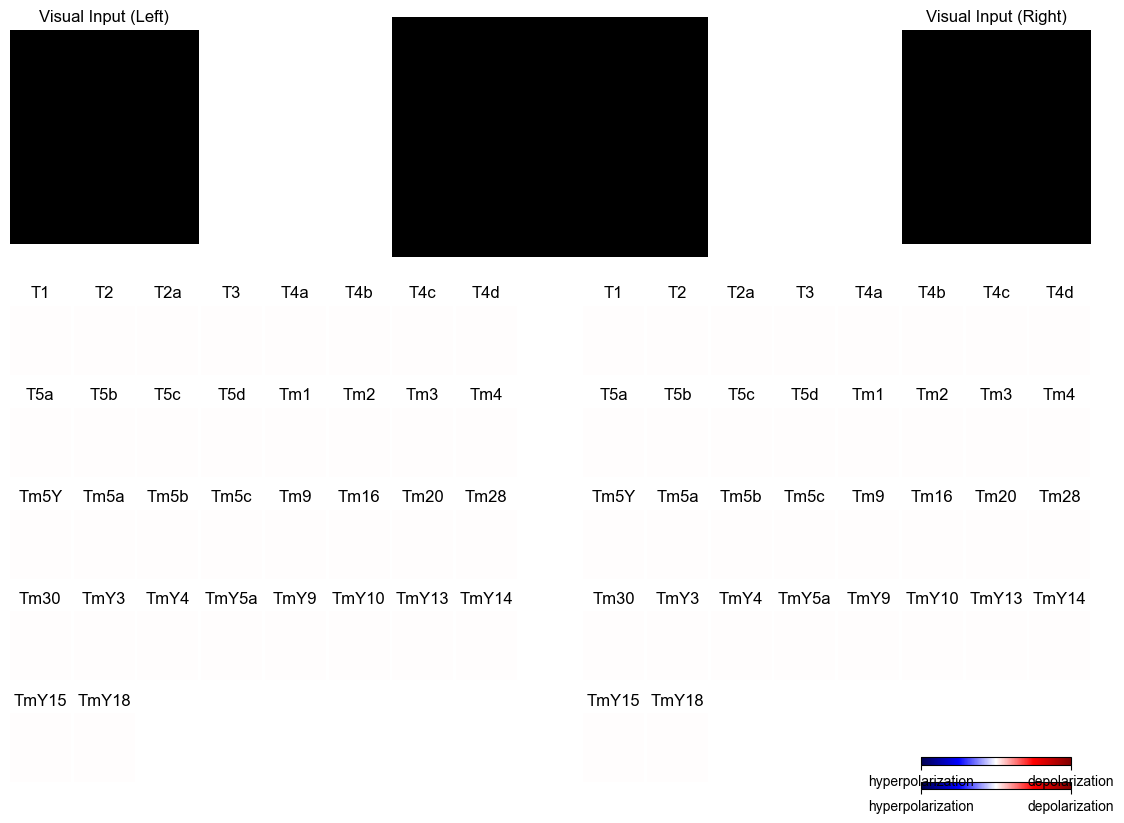

In [5]:
def process_trial(behavior, speed, terrain):
    variation_name = behavior + "_terrain_" + terrain + "_speed_" + str(speed)
    stabilization_model = HeadStabilizationInferenceWrapper(
        model_path=stabilization_model_path,
        scaler_param_path=scaler_param_path,
    )

    if(terrain == "Optomotor"):
        trial_terrain = OptomotorTerrain(ang_speed = speed)
    elif(terrain == "Looming"):
        trial_terrain = LoomingTerrain(move_speed = speed)
    else:
        print("Error while choosing terrain type.")
        return

    # Run simulation
    res = run_simulation(
        fly_behavior = behavior,
        arena=trial_terrain,
        run_time=0.5,
        head_stabilization_model=stabilization_model,
    )

    # Save visualization
    visualize_vision(
        Path(output_dir) / f"{variation_name}.mp4",
        res["sim"].fly.retina,
        res["sim"].retina_mapper,
        rendered_image_hist=res["rendered_image_snapshots"],
        vision_observation_hist=res["vision_observation_snapshots"],
        nn_activities_hist=res["nn_activities_snapshots"],
        fps=res["sim"].cameras[0].fps,
    )

    # Save median and std of response for each cell
    response_stats = {}
    for cell in cells:
        response_all = np.array(
            [info["nn_activities"][cell] for info in res["info_hist"]]
        )
        response_mean = np.mean(response_all, axis=0)
        response_std = np.std(response_all, axis=0)
        response_stats[cell] = {
            "all": res["sim"].retina_mapper.flyvis_to_flygym(response_all),
            "mean": res["sim"].retina_mapper.flyvis_to_flygym(response_mean),
            "std": res["sim"].retina_mapper.flyvis_to_flygym(response_std),
        }
    with open(output_dir / f"{variation_name}_stats.pkl", "wb") as f:
        pickle.dump(response_stats, f)


if __name__ == "__main__":
    output_dir.mkdir(exist_ok=True, parents=True)
    configs = [
        (behavior, speed, terrain)
        # Here are the possibilities to choose from for the behavior and terrain types:
        #  - for behavior: "Immobile", "SimpleSTDT4", "AdaptativeSTDT4","SimpleSTDT45" ,"AdaptativeSTDT45", "RealisticProportional"
        #  - for terrain: "Optomotor", "Looming"
        # It is better to choose a speed that is not too big, inferior to 10
        for behavior in ["AdaptativeSTDT45"]
        for speed in [3]
        for terrain in ["Optomotor"]
    ]
    # Uncomment the next line and comment the following ones for multi=processing. Requires A LOT of ram, more than 32 Go.
    #Parallel(backend='multiprocessing', n_jobs=9)(delayed(process_trial)(*config) for config in configs)
    
    for config in configs:  
        process_trial(*config)